# Chapter 3. 신경망

In [620]:
import numpy as np

def step_function(x):
    y = x > 0
    return y.astype(np.int)

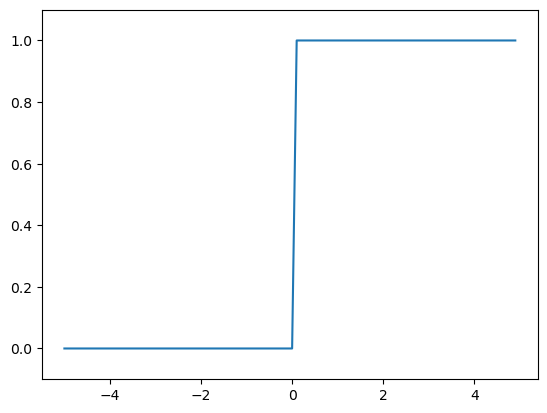

In [621]:
# 계단 함수의 그래프
import numpy as np
import matplotlib.pylab as plt

def step_function(x):
    return np.array(x > 0, dtype=int)

x = np.arange(-5.0, 5.0, 0.1)
y = step_function(x)
plt.plot(x, y)
plt.ylim(-0.1, 1.1)
plt.show()

In [622]:
# sigmoid, relu, softmax

def sigmoid(x):
    return 1/(1+np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def softmax(a):
    c = np.max(a)
    exp_a = np.exp(a-c)
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a
    return y

In [623]:
# 행렬 연산
A = np.array([1,2])
print(A.shape)
B = np.array([[3,4,5], [5,6,7]])
print(B.shape)
np.dot(A,B)

(2,)
(2, 3)


array([13, 16, 19])

In [624]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import pickle
import tensorflow as tf
mnist = tf.keras.datasets.mnist

def get_data():
    (x_train, t_train), (x_test, t_test) = mnist.load_data()
    x_test = x_test.astype('float32') / 255.0
    x_test = x_test.reshape(x_test.shape[0], -1)  # Flatten
    return x_test, t_test

def init_network():
    with open("sample_weight.pkl", 'rb') as f:
        network = pickle.load(f)
    return network


def predict(network, x):
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']

    a1 = np.dot(x, W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    z2 = sigmoid(a2)
    a3 = np.dot(z2, W3) + b3
    y = softmax(a3)

    return y


x, t = get_data()
network = init_network()
accuracy_cnt = 0
for i in range(len(x)):
    y = predict(network, x[i])
    p= np.argmax(y) # 확률이 가장 높은 원소의 인덱스를 얻는다.
    if p == t[i]:
        accuracy_cnt += 1

print("Accuracy:" + str(float(accuracy_cnt) / len(x)))

Accuracy:0.9352


# Chapter 4 신경망 학습

In [625]:
# SSE, cross_entropy_error
def sum_squares_error(y, t):
    return 0.5 * np.sum((y-t)**2)

def cross_entropy_error(y, t):
    delta = 1e-7
    return -np.sum(t*np.log(y+delta))


In [626]:
(x_train, t_train), (x_test, t_test) = mnist.load_data()

print(x_train.shape)
print(t_train.shape)
print(x_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)


In [627]:
# numpy로 원-핫 인코딩
num_classes  = 10
t_train = np.eye(num_classes)[t_train]
t_test = np.eye(num_classes)[t_test]

print(t_train.shape, t_test.shape)

(60000, 10) (10000, 10)


In [628]:
# 배치화
np.random.seed(42)

train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)

x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

In [629]:
# 배치용 CSE 구현
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, t.size)
    
    t = t.argmax(axis=1)
    batch_size = y.shape[0]
    print(y[np.arange(batch_size), t].shape)
    print(y[np.arange(batch_size), t])
    return -np.sum(t*np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [630]:
# 예측 확률 분포 (softmax 출력)
y = np.array([[0.1, 0.7, 0.2],  # 첫 번째 샘플
              [0.3, 0.4, 0.3],  # 두 번째 샘플
              [0.2, 0.1, 0.7]]) # 세 번째 샘플

# 실제 레이블 (원-핫 인코딩)
t = np.array([[0, 1, 0],  # 첫 번째 샘플의 실제 클래스: 1
              [1, 0, 0],  # 두 번째 샘플의 실제 클래스: 0
              [0, 0, 1]]) # 세 번째 샘플의 실제 클래스: 2

# 교차 엔트로피 손실 계산
loss = cross_entropy_error(y, t)
print(f"Cross Entropy Error: {loss:.4f}")

(3,)
[0.7 0.3 0.7]
Cross Entropy Error: 0.3567


In [631]:
# 수치 미분
def numerical_diff(f, x):
    h = 1e-4
    return (f(x+h) - f(x-h)) / (2*h)

# 편미분
def numerical_gradient_1d(f, x):
    h = 1e-4
    grad = np.zeros_like(x)

    for idx in range(x.size):
        tmp = x[idx]
        x[idx] = tmp + h
        fxh1 = f(x)

        x[idx] = tmp - h
        fxh2 = f(x)

        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp

    return grad

def numerical_gradient_2d(f, x):
    if x.ndim == 1:
        return numerical_gradient_1d(f, x)
    else:
        grad = np.zeros_like(x)

        for idx, x in enumerate(x):
            grad[idx] = numerical_gradient_1d(f, x)
        
        return grad

In [632]:
# 경사하강법법
def gradient_descent(f, init_x, lr = 0.01, step_num=100):
    x = init_x

    for i in range(step_num):
        grad = numerical_gradient_2d(f, x)
        x -= lr*grad
    return x

In [633]:
# 함수에서의 기울기기
def function_2(x):
    return x[0]**2+x[1]**2

init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x=init_x, lr= 0.1, step_num=100)

array([-6.11110793e-10,  8.14814391e-10])

In [634]:
# 신경망에서의 기울기
import numpy as np
np.random.seed(42)

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, t.size)
    
    t = t.argmax(axis=1)
    batch_size = y.shape[0]
    return -np.sum(t*np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2, 3)
    
    def predict(self, x):
        return np.dot(x, self.W)
    
    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)

        return loss
    
net = simpleNet()
print(net.W)

[[ 0.49671415 -0.1382643   0.64768854]
 [ 1.52302986 -0.23415337 -0.23413696]]


In [635]:
x = np.array([0.6, 0.8])
p = net.predict(x)
print(p)

[ 1.51645238 -0.27028128  0.20130356]


In [636]:
t = np.array([0.0, 0.0, 1])
net.loss(x, t)

3.353937033131167

In [637]:
def f(W):
    return net.loss(x, t)

dW = numerical_gradient_2d(f, net.W)
print(dW) 

[[ 0.83568861  0.1399832  -0.97567181]
 [ 1.11425148  0.18664427 -1.30089575]]


In [638]:
# 2층 신경망 클래스
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, t.size)
    
    # t = t.argmax(axis=1)
    batch_size = y.shape[0]
    return -np.sum(t*np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):

        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']

        x = x.reshape(x.shape[0], -1)
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        z2 = sigmoid(a2)
        y = softmax(z2)

        return y
    
    def loss(self, x, t):
        y = self.predict(x)
        return cross_entropy_error(y, t)
    
    def accurracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        # t = np.argmax(t, axis=1)
        print(y.shape, t.shape)
        accuracy = np.sum((y == t)) / y.size
        # accuracy = np.sum((y == t)) / float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient_2d(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient_2d(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient_2d(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient_2d(loss_W, self.params['b2'])

        return grads

In [639]:
# np.random.seed(42)

# net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
# x = np.random.rand(100, 784)
# t = np.random.rand(100, 10)
# y = net.predict(x)

# print(net.accurracy(x, t))

In [640]:
# grads = net.numerical_gradient(x, t)
# grads['W1'].shape

In [641]:
# (x_train, t_train), (x_test, t_test) = mnist.load_data()

# train_loss_list = []

# iters_num = 10000
# train_size = x_train.shape[0]
# batch_size = 100
# learning_rate = 0.1

# network = TwoLayerNet(input_size= 784, hidden_size= 50, output_size= 10)

# for i in range(iters_num):

#     batch_mask = np.random.choice(train_size, batch_size)
#     x_batch = x_train[batch_mask]
#     t_batch = t_train[batch_mask]

#     grad = network.numerical_gradient(x_batch, t_batch)

#     for key in ('W1', 'b1', 'W2', 'b2'):
#         network.params[key] -= learning_rate * grad[key]

#     loss = network.loss(x_batch, t_batch)
#     train_loss_list.append(loss)

In [642]:
# (x_train, t_train), (x_test, t_test) = mnist.load_data()

# train_loss_list = []
# train_acc_list = []
# test_acc_list = []

# iters_num = 10000
# train_size = x_train.shape[0]
# batch_size = 100
# learning_rate = 0.1

# network = TwoLayerNet(input_size= 784, hidden_size= 50, output_size= 10)

# iter_per_epoch = max(train_size / batch_size, 1)

# for i in range(iters_num):

#     batch_mask = np.random.choice(train_size, batch_size)
#     x_batch = x_train[batch_mask]
#     t_batch = t_train[batch_mask]

#     grad = network.numerical_gradient(x_batch, t_batch)

#     for key in ('W1', 'b1', 'W2', 'b2'):
#         network.params[key] -= learning_rate * grad[key]

#     loss = network.loss(x_batch, t_batch)
#     train_loss_list.append(loss)

#     if i % iter_per_epoch == 0:
#         train_acc = network.accurracy(x_train, t_train)
#         test_acc = network.accurracy(x_test, t_test)
#         train_acc_list.append(train_acc)
#         test_acc_list.append(test_acc)
#         print("train_acc test acc | " + str(train_acc) + ", " + str(test_acc))

# Chapter 5. 오차역전파법

In [643]:
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None
    
    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x*y
        return out

    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x

        return dx, dy

In [644]:
apple = 100.0
apple_num = 2.0
tax = 1.1

mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

print(price)


dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(dapple, dapple_num, dtax)

220.00000000000003
2.2 110.00000000000001 200.0


In [645]:
class AddLayer:
    def __init__(self):
        pass
    
    def forward(self, x, y):
        out = x+y
        return out

    def backward(self, dout):
        dx = dout
        dy = dout

        return dx, dy

In [646]:
class Relu:
    def __init__(self):
        self.mask = None
    
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

In [647]:
class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = 1 / (1+np.exp(-x))
        self.out = out

        return out
    
    def backward(self, dout):
        dx = dout * (1 - self.out) * self.out
        return dx

In [648]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout , self.W.T)
        # print(dx.shape, dout.shape, self.W.shape)
        self.dW = np.dot(self.x.T, dout)
        # print(self.dW)
        self.db = np.sum(dout, axis = 0)

        return dx

In [649]:
def softmax(x):
    if x.ndim == 2:
        x = x - np.max(x, axis=1, keepdims=True)
        return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)
    x = x - np.max(x) 
    return np.exp(x) / np.sum(np.exp(x))

class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None
    
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss
    
    def backward(self, dout = 1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        
        return dx * dout

In [650]:
# 2층 신경망 클래스
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, t.size)
    
    if t.size == y.size:
        t = t.argmax(axis=1)
    batch_size = y.shape[0]
    return -np.sum(t*np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

def numerical_gradient_1d(f, x):
    h = 1e-4
    grad = np.zeros_like(x)

    for idx in range(x.size):
        tmp = x[idx]
        x[idx] = tmp + h
        fxh1 = f(x)

        x[idx] = tmp - h
        fxh2 = f(x)

        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp

    return grad

def numerical_gradient_2d(f, x):
    if x.ndim == 1:
        return numerical_gradient_1d(f, x)
    else:
        grad = np.zeros_like(x)

        for idx, row in enumerate(x):
            grad[idx] = numerical_gradient_1d(f, row)
        
        return grad

from collections import OrderedDict

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):

        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.lastlayers = SoftmaxWithLoss()

    def predict(self, x):
        # print(x.shape)
        x = x.reshape(x.shape[0], -1)
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastlayers.forward(y, t)
    
    def accurracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        # print(y.shape, t.shape)
        # accuracy = np.sum((y == t)) / y.size
        accuracy = np.sum((y == t)) / float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient_2d(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient_2d(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient_2d(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient_2d(loss_W, self.params['b2'])

        return grads
    
    def gradient(self, x, t):
        self.loss(x, t)

        dout = 1
        dout = self.lastlayers.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db

        return grads

In [657]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist

np.random.seed(42)

(x_train, t_train), (x_test, t_test) = mnist.load_data()

# 원핫 벡터로 변환
num_classes = 10
t_train = np.eye(num_classes)[t_train]
t_test = np.eye(num_classes)[t_test]

x_train = x_train / 255.0
x_test = x_test / 255.0

network = TwoLayerNet(input_size = 784, hidden_size= 50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

print(x_train.shape, x_batch.shape)

grad_backprop = network.gradient(x_batch, t_batch)
# print(grad_backprop)
grad_numerical = network.numerical_gradient(x_batch, t_batch)
# print(grad_numerical)
for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(key + ": " + str(diff))

(60000, 28, 28) (3, 28, 28)
W1: 5.019833973364654e-10
b1: 2.7025218238361375e-09
W2: 5.7881141598110936e-09
b2: 1.3945938001636016e-07


In [658]:
import numpy as np
np.random.seed(42)

(x_train, t_train), (x_test, t_test) = mnist.load_data()

# 원핫 벡터로 변환
num_classes = 10
t_train = np.eye(num_classes)[t_train]
t_test = np.eye(num_classes)[t_test]

x_train = x_train / 255.0
x_test = x_test / 255.0

network = TwoLayerNet(input_size = 784, hidden_size= 50, output_size=10)

train_loss_list = []
train_acc_list = []
test_acc_list = []

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):

    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grad = network.gradient(x_batch, t_batch)

    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    if i % iter_per_epoch == 0:
        train_acc = network.accurracy(x_train, t_train)
        test_acc = network.accurracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train_acc test acc | " + str(train_acc) + ", " + str(test_acc))

train_acc test acc | 0.10226666666666667, 0.1009
train_acc test acc | 0.9036166666666666, 0.9055
train_acc test acc | 0.9244666666666667, 0.9254
train_acc test acc | 0.9370666666666667, 0.9368
train_acc test acc | 0.9437666666666666, 0.9424
train_acc test acc | 0.95245, 0.951
train_acc test acc | 0.9548833333333333, 0.9529
train_acc test acc | 0.9593833333333334, 0.957
train_acc test acc | 0.96375, 0.9596
train_acc test acc | 0.96675, 0.9601
train_acc test acc | 0.96825, 0.9631
train_acc test acc | 0.9701, 0.9655
train_acc test acc | 0.9714166666666667, 0.9647
train_acc test acc | 0.9726833333333333, 0.9663
train_acc test acc | 0.9753166666666667, 0.9672
train_acc test acc | 0.9756333333333334, 0.968
train_acc test acc | 0.9778333333333333, 0.9699


In [668]:
class SGD:
    def __init__(self, lr = 0.01) :
        self.lr = lr
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

class Momentum:
    def __init__(self, lr = 0.01, momentum = 0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
    
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

class Nesterov:
    def __init__(self, lr = 0.01, momentum = 0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
    
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
        
        for key in params.keys():
            prev_v = self.v[key]
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += -self.momentum * prev_v + (1 + self.momentum) * self.v[key]

class AdaGrad:
    def __init__(self, lr = 0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

In [669]:
import numpy as np
np.random.seed(42)

(x_train, t_train), (x_test, t_test) = mnist.load_data()

# 원핫 벡터로 변환
num_classes = 10
t_train = np.eye(num_classes)[t_train]
t_test = np.eye(num_classes)[t_test]

x_train = x_train / 255.0
x_test = x_test / 255.0

network = TwoLayerNet(input_size = 784, hidden_size= 50, output_size=10)
# optimizer = SGD()
# optimizer = Momentum()
# optimizer = Nesterov()
optimizer = Adam()

train_loss_list = []
train_acc_list = []
test_acc_list = []

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):

    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grad = network.gradient(x_batch, t_batch)

    # for key in ('W1', 'b1', 'W2', 'b2'):
    #     network.params[key] -= learning_rate * grad[key]
    optimizer.update(network.params, grads = grad)

    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    if i % iter_per_epoch == 0:
        train_acc = network.accurracy(x_train, t_train)
        test_acc = network.accurracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train_acc test acc | " + str(train_acc) + ", " + str(test_acc))

train_acc test acc | 0.16891666666666666, 0.1666
train_acc test acc | 0.9198666666666667, 0.921
train_acc test acc | 0.9369333333333333, 0.9367
train_acc test acc | 0.9475666666666667, 0.9435
train_acc test acc | 0.95665, 0.9543
train_acc test acc | 0.9616, 0.9587
train_acc test acc | 0.9671333333333333, 0.9631
train_acc test acc | 0.9701333333333333, 0.9647
train_acc test acc | 0.9739, 0.9674
train_acc test acc | 0.97625, 0.9687
train_acc test acc | 0.9786333333333334, 0.9709
train_acc test acc | 0.9802666666666666, 0.9708
train_acc test acc | 0.9806666666666667, 0.9704
train_acc test acc | 0.9810833333333333, 0.9696
train_acc test acc | 0.98515, 0.9722
train_acc test acc | 0.98505, 0.9711
train_acc test acc | 0.987, 0.9728


# Chapter 6. 학습 관련 기술들

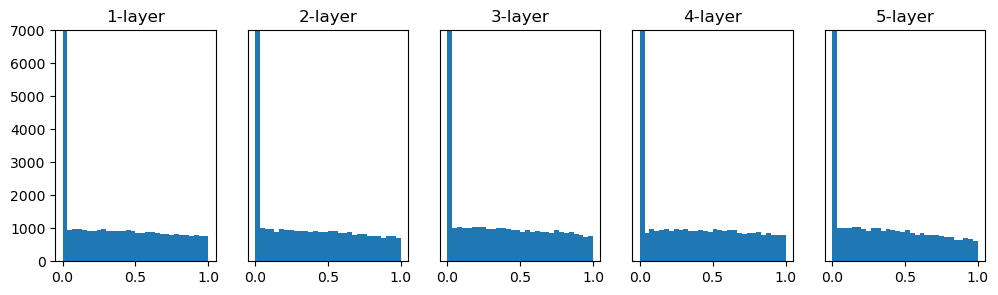

In [679]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)


input_data = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 이곳에 활성화 결과를 저장

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 초깃값을 다양하게 바꿔가며 실험해보자！
    # w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)

    a = np.dot(x, w)

    # 활성화 함수도 바꿔가며 실험해보자！
    # z = sigmoid(a)
    z = ReLU(a)
    # z = tanh(a)

    activations[i] = z
plt.figure(figsize=(12, 3))
# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0:
        plt.yticks([], [])
    # plt.xlim(0.1, 1)
    plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0, 1))

plt.show()

In [ ]:
# coding: utf-8
import numpy as np


def smooth_curve(x):
    """손실 함수의 그래프를 매끄럽게 하기 위해 사용
    
    참고：http://glowingpython.blogspot.jp/2012/02/convolution-with-numpy.html
    """
    window_len = 11
    s = np.r_[x[window_len-1:0:-1], x, x[-1:-window_len:-1]]
    w = np.kaiser(window_len, 2)
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[5:len(y)-5]


def shuffle_dataset(x, t):
    """데이터셋을 뒤섞는다.

    Parameters
    ----------
    x : 훈련 데이터
    t : 정답 레이블
    
    Returns
    -------
    x, t : 뒤섞은 훈련 데이터와 정답 레이블
    """
    permutation = np.random.permutation(x.shape[0])
    x = x[permutation, :] if x.ndim == 2 else x[permutation, :, :, :]
    t = t[permutation]

    return x, t

def conv_output_size(input_size, filter_size, stride=1, pad=0):
    return (input_size + 2*pad - filter_size) / stride + 1


def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """다수의 이미지를 입력받아 2차원 배열로 변환한다(평탄화).
    
    Parameters
    ----------
    input_data : 4차원 배열 형태의 입력 데이터(이미지 수, 채널 수, 높이, 너비)
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    col : 2차원 배열
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col


def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """(im2col과 반대) 2차원 배열을 입력받아 다수의 이미지 묶음으로 변환한다.
    
    Parameters
    ----------
    col : 2차원 배열(입력 데이터)
    input_shape : 원래 이미지 데이터의 형상（예：(10, 1, 28, 28)）
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    img : 변환된 이미지들
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]